   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.6 MB/s eta 0:00:00
📂 Upload your content.jpg and style.jpg


Saving style.jpg to style (1).jpg


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.7MB/s]


🎨 Stylizing...
Step 50 | Style: 0.00 | Content: 22.17
Step 100 | Style: 0.00 | Content: 19.94
Step 150 | Style: 0.00 | Content: 17.93
Step 200 | Style: 0.00 | Content: 16.41
Step 250 | Style: 0.00 | Content: 15.51
Step 300 | Style: 0.00 | Content: 14.88


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


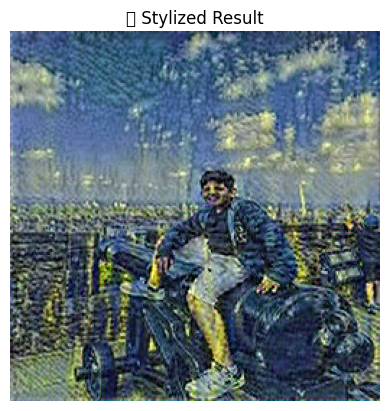

✅ Stylized image saved as stylized_result.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🧠 Neural Style Transfer in Google Colab
!pip install -q torch torchvision pillow matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt
import copy
from google.colab import files

# === STEP 1: Upload Files ===S
print("📂 Upload your content.jpg and style.jpg")
uploaded = files.upload()

# === STEP 2: Prepare Device and Preprocessing ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_path, target_shape=None):
    image = Image.open(image_path).convert('RGB')
    if target_shape:
        image = image.resize(target_shape, Image.LANCZOS)
    else:
        image = image.resize((imsize, imsize), Image.LANCZOS)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# === STEP 3: Load Images ===
content_img = image_loader("content.jpg")
_, _, h, w = content_img.shape
style_img = image_loader("style.jpg", target_shape=(w, h))

# === STEP 4: Image Display Helper ===
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# === STEP 5: Content & Style Losses ===
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

# === STEP 6: Normalization ===
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

# === STEP 7: Load VGG19 ===
weights = VGG19_Weights.DEFAULT
cnn = vgg19(weights=weights).features.to(device).eval()

# Layers for losses
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Model builder
def get_style_model_and_losses(cnn, norm_mean, norm_std,
                                style_img, content_img,
                                style_layers, content_layers):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(norm_mean, norm_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

# === STEP 8: Stylize ===
input_img = content_img.clone()
input_img.requires_grad_(True)

def run_style_transfer(cnn, norm_mean, norm_std,
                       content_img, style_img, input_img,
                       num_steps=300, style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, norm_mean, norm_std, style_img, content_img,
        style_layers, content_layers
    )
    optimizer = optim.LBFGS([input_img])

    print('🎨 Stylizing...')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]} | Style: {style_score.item():.2f} | Content: {content_score.item():.2f}")
            return style_score + content_score
        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

# Run style transfer
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# Show result
imshow(output, title="🖼 Stylized Result")

# Save output
output_image = transforms.ToPILImage()(output.cpu().squeeze(0))
output_image.save("stylized_result.jpg")
print("✅ Stylized image saved as stylized_result.jpg")

# Offer download
files.download("stylized_result.jpg")
